In [1]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
# --- Load forecast log ---
forecast_df = pd.read_csv("../../results/model_forecasts_log.csv", parse_dates=["Date"])

In [3]:
# Load without parsing
df_raw = pd.read_csv("../../results/model_forecasts_log.csv", parse_dates=["Date"])

# Show unique model names (raw)
print("🔍 Unique Model Names:")
print(df_raw["Model"].unique())

# Count rows per model
print("\n🔢 Forecast counts per model:")
print(df_raw["Model"].value_counts())


🔍 Unique Model Names:
['ARIMA' 'SARIMA' 'ARIMAX' 'SARIMAX' 'Prophet' 'Prophet + Exog'
 'Random Forest (Univariate)' 'Random Forest (Multivariate)'
 'XGBoost (Univariate)' 'XGBoost (Univariate gold_lag_7)'
 'XGBoost (Univariate gold_lag_30)' 'XGBoost (Univariate - all lags)'
 'XGBoost (Multivariate)' 'Random Forest (Tuned)' 'XGBoost (Tuned)' 'LSTM'
 'LSTM (Multivariate)' 'LSTM (Semi-Multivariate)']

🔢 Forecast counts per model:
Model
ARIMA                               251
XGBoost (Univariate)                251
XGBoost (Tuned)                     251
Random Forest (Tuned)               251
XGBoost (Multivariate)              251
XGBoost (Univariate - all lags)     251
XGBoost (Univariate gold_lag_30)    251
SARIMA                              251
XGBoost (Univariate gold_lag_7)     251
Random Forest (Multivariate)        251
Random Forest (Univariate)          251
Prophet + Exog                      251
Prophet                             251
SARIMAX                             251
ARI

In [4]:
# Normalize model names and dates
forecast_df["Model"] = forecast_df["Model"].str.strip()
forecast_df["Date"] = pd.to_datetime(forecast_df["Date"], errors="coerce").dt.normalize()
# ✅ Confirm model counts
print("✅ Unique models:", forecast_df["Model"].unique())
print("✅ Date range:", forecast_df["Date"].min(), "→", forecast_df["Date"].max())
print("✅ Rows per model:\n", forecast_df["Model"].value_counts())



✅ Unique models: ['ARIMA' 'SARIMA' 'ARIMAX' 'SARIMAX' 'Prophet' 'Prophet + Exog'
 'Random Forest (Univariate)' 'Random Forest (Multivariate)'
 'XGBoost (Univariate)' 'XGBoost (Univariate gold_lag_7)'
 'XGBoost (Univariate gold_lag_30)' 'XGBoost (Univariate - all lags)'
 'XGBoost (Multivariate)' 'Random Forest (Tuned)' 'XGBoost (Tuned)' 'LSTM'
 'LSTM (Multivariate)' 'LSTM (Semi-Multivariate)']
✅ Date range: 2024-01-02 00:00:00 → 2024-12-30 00:00:00
✅ Rows per model:
 Model
ARIMA                               251
XGBoost (Univariate)                251
XGBoost (Tuned)                     251
Random Forest (Tuned)               251
XGBoost (Multivariate)              251
XGBoost (Univariate - all lags)     251
XGBoost (Univariate gold_lag_30)    251
SARIMA                              251
XGBoost (Univariate gold_lag_7)     251
Random Forest (Multivariate)        251
Random Forest (Univariate)          251
Prophet + Exog                      251
Prophet                             251
SAR

In [5]:
# --- Normalize datetime format ---
forecast_df["Date"] = pd.to_datetime(forecast_df["Date"], errors="coerce").dt.normalize()
forecast_df.dropna(subset=["Date"], inplace=True)

# --- Check available models ---
print("✅ Available models:")
print(forecast_df["Model"].unique())


✅ Available models:
['ARIMA' 'SARIMA' 'ARIMAX' 'SARIMAX' 'Prophet' 'Prophet + Exog'
 'Random Forest (Univariate)' 'Random Forest (Multivariate)'
 'XGBoost (Univariate)' 'XGBoost (Univariate gold_lag_7)'
 'XGBoost (Univariate gold_lag_30)' 'XGBoost (Univariate - all lags)'
 'XGBoost (Multivariate)' 'Random Forest (Tuned)' 'XGBoost (Tuned)' 'LSTM'
 'LSTM (Multivariate)' 'LSTM (Semi-Multivariate)']


In [6]:
# --- Select models to include in ensemble ---
top_models = [
    "LSTM (Semi-Multivariate)",
    "XGBoost (Tuned)",
    "Prophet"
]


In [7]:
# --- Filter only those models and 2024 dates using a date range ---
ensemble_df = forecast_df[
    (forecast_df["Model"].isin(top_models)) &
    (forecast_df["Date"] >= "2024-01-01") &
    (forecast_df["Date"] <= "2024-12-31")
].copy()


In [8]:
# --- Pivot forecasts to wide format ---
pivot_df = ensemble_df.pivot_table(
    index="Date",
    columns="Model",
    values="Forecast"
).reset_index()


In [9]:
# --- Also include actual values from one of the models
actual_df = forecast_df[
    (forecast_df["Model"] == top_models[0]) &
    (forecast_df["Date"] >= "2024-01-01") &
    (forecast_df["Date"] <= "2024-12-31")
][["Date", "Actual"]].drop_duplicates()


In [11]:
# Merge forecasts with actuals
merged_df = pd.merge(pivot_df, actual_df, on="Date", how="left")

# Drop rows with missing forecasts (due to LSTM starting later)
merged_df.dropna(subset=top_models, inplace=True)

# ✅ Check
print("✅ Merged Data for Ensemble (after dropping NaNs):")
print(merged_df.head())


✅ Merged Data for Ensemble (after dropping NaNs):
         Date  LSTM (Semi-Multivariate)      Prophet  XGBoost (Tuned)  Actual
30 2024-02-14               2023.163334  1986.311278      1990.853027  1990.3
31 2024-02-15               2013.680925  1987.539152      2006.001709  2002.1
32 2024-02-16               2009.399614  1987.963990      2007.267456  2011.5
33 2024-02-20               2009.351123  1990.314481      2029.500610  2027.5
34 2024-02-21               2014.681528  1990.980793      2018.454102  2022.3


In [12]:
# --- Create Ensemble Forecast ---
merged_df["Ensemble_Forecast"] = merged_df[top_models].mean(axis=1)


In [13]:
# --- Evaluation ---
y_true = merged_df["Actual"]
y_pred = merged_df["Ensemble_Forecast"]

mae_ensemble = mean_absolute_error(y_true, y_pred)
rmse_ensemble = np.sqrt(mean_squared_error(y_true, y_pred))
r2_ensemble = r2_score(y_true, y_pred)

print("\n📊 Ensemble Performance on 2024:")
print(f"MAE: {mae_ensemble:.2f}")
print(f"RMSE: {rmse_ensemble:.2f}")
print(f"R² Score: {r2_ensemble:.4f}")



📊 Ensemble Performance on 2024:
MAE: 276.41
RMSE: 304.48
R² Score: -1.5383


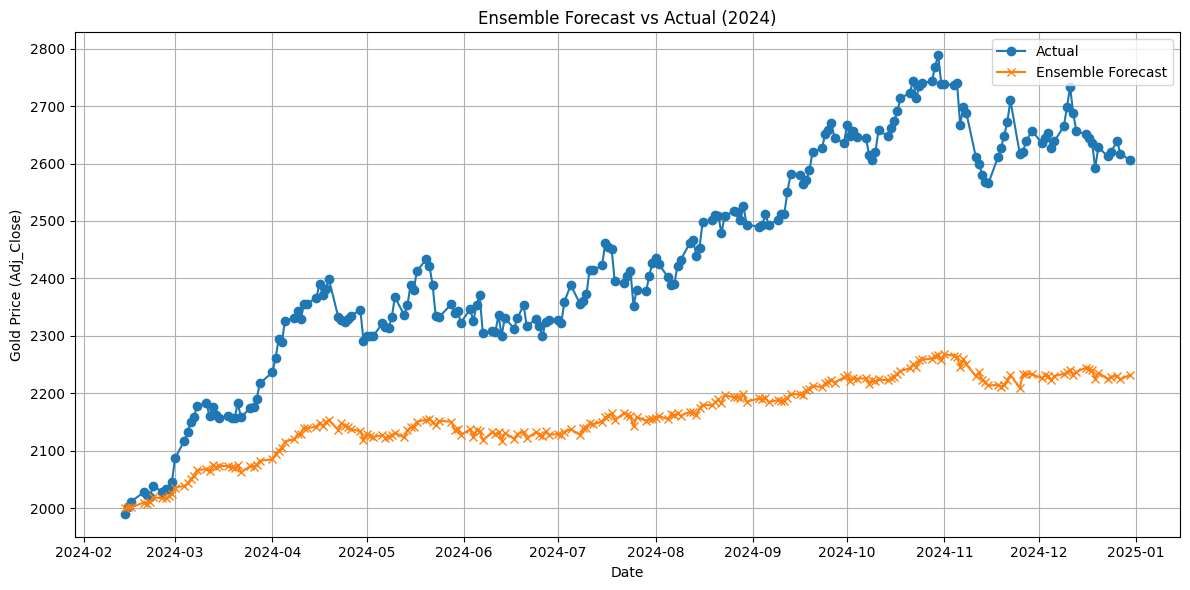

In [14]:
# --- Plot Ensemble Forecast ---
plt.figure(figsize=(12, 6))
plt.plot(merged_df["Date"], merged_df["Actual"], label="Actual", marker='o')
plt.plot(merged_df["Date"], merged_df["Ensemble_Forecast"], label="Ensemble Forecast", marker='x')
plt.title("Ensemble Forecast vs Actual (2024)")
plt.xlabel("Date")
plt.ylabel("Gold Price (Adj_Close)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


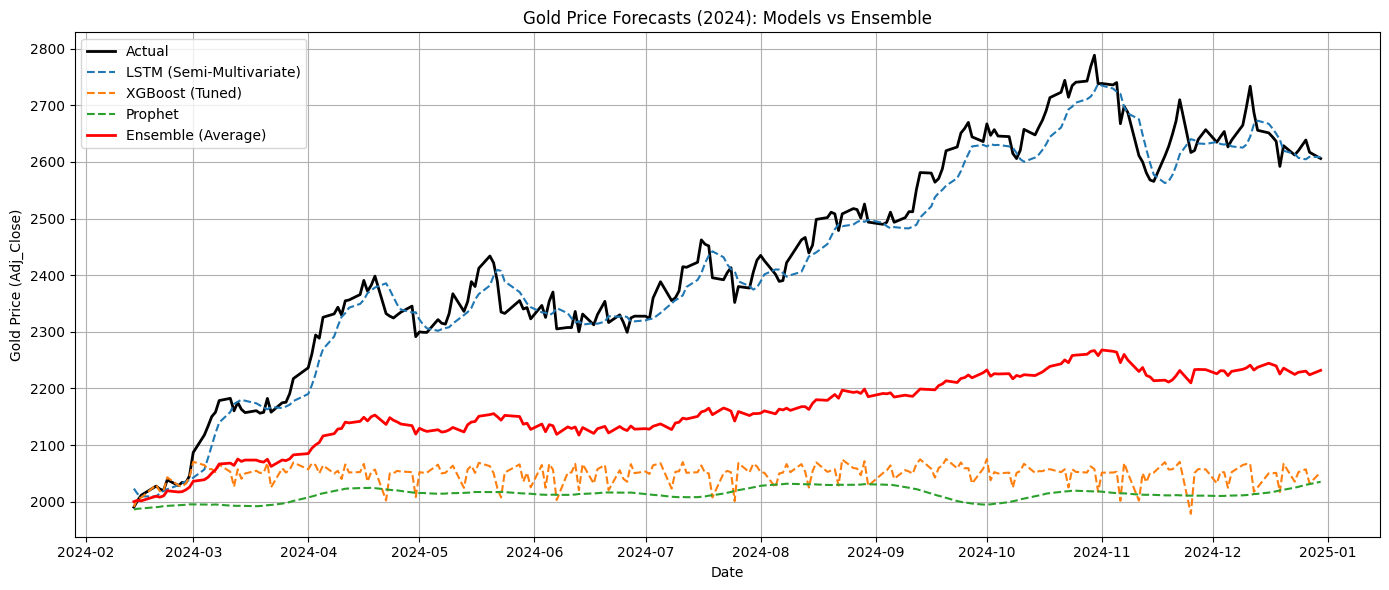

In [15]:
# --- Plot All Forecasts vs Actual (2024) ---
plt.figure(figsize=(14, 6))

# Plot actual values
plt.plot(merged_df["Date"], merged_df["Actual"], label="Actual", color="black", linewidth=2)

# Plot each model
plt.plot(merged_df["Date"], merged_df["LSTM (Semi-Multivariate)"], label="LSTM (Semi-Multivariate)", linestyle="--")
plt.plot(merged_df["Date"], merged_df["XGBoost (Tuned)"], label="XGBoost (Tuned)", linestyle="--")
plt.plot(merged_df["Date"], merged_df["Prophet"], label="Prophet", linestyle="--")

# Compute and plot ensemble (simple average)
merged_df["Ensemble_Avg"] = merged_df[["LSTM (Semi-Multivariate)", "XGBoost (Tuned)", "Prophet"]].mean(axis=1)
plt.plot(merged_df["Date"], merged_df["Ensemble_Avg"], label="Ensemble (Average)", color="red", linewidth=2)

# Final touches
plt.title("Gold Price Forecasts (2024): Models vs Ensemble")
plt.xlabel("Date")
plt.ylabel("Gold Price (Adj_Close)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
# --- MAE Scores from previous model evaluations ---
mae_scores = {
    "LSTM (Semi-Multivariate)": 27.75,
    "XGBoost (Tuned)": 343.11,
    "Prophet": 272.19
}

In [22]:
# Compute inverse MAE
inv_mae = {model: 1 / mae for model, mae in mae_scores.items()}

# Normalize to get weights
total_inv = sum(inv_mae.values())
weights = {model: val / total_inv for model, val in inv_mae.items()}

# ✅ Print weights
print("📊 Ensemble Weights based on Inverse MAE:")
for model, weight in weights.items():
    print(f"{model}: {weight:.2%}")


📊 Ensemble Weights based on Inverse MAE:
LSTM (Semi-Multivariate): 84.54%
XGBoost (Tuned): 6.84%
Prophet: 8.62%


In [24]:
# --- Compute weighted ensemble forecast ---
merged_df["Ensemble_Weighted"] = (
    merged_df["LSTM (Semi-Multivariate)"] * weights["LSTM (Semi-Multivariate)"] +
    merged_df["XGBoost (Tuned)"] * weights["XGBoost (Tuned)"] +
    merged_df["Prophet"] * weights["Prophet"]
)

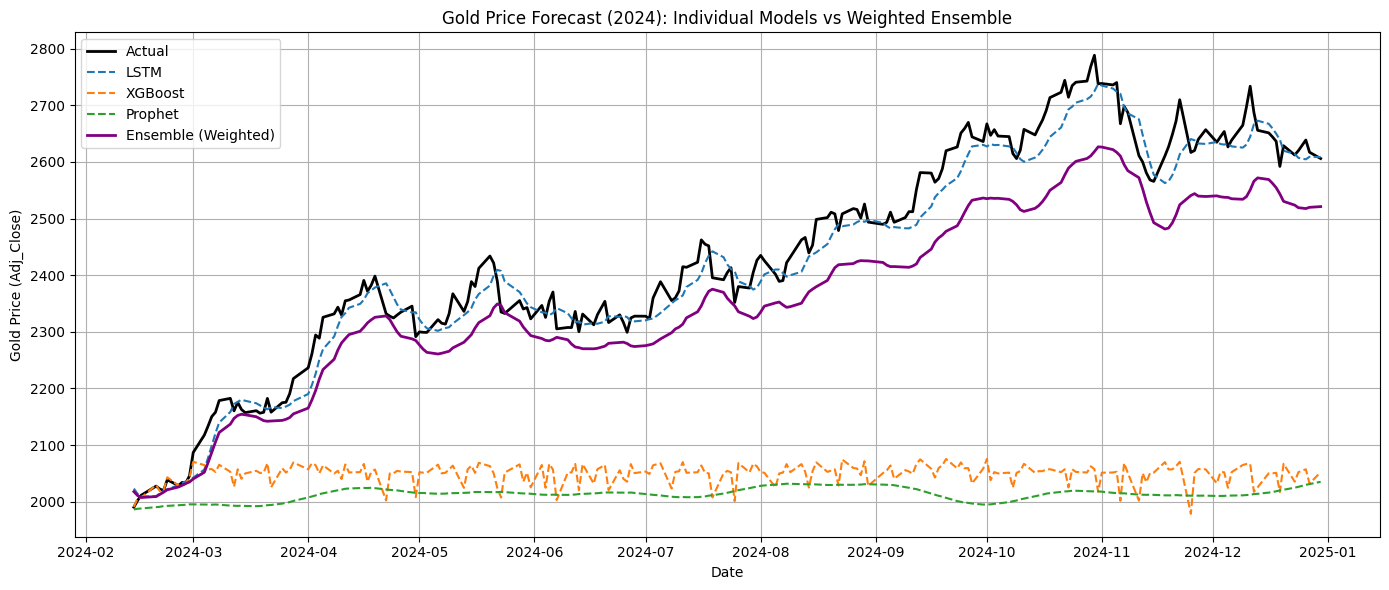

In [25]:
# Plot all forecasts including weighted ensemble
plt.figure(figsize=(14, 6))
plt.plot(merged_df["Date"], merged_df["Actual"], label="Actual", color="black", linewidth=2)
plt.plot(merged_df["Date"], merged_df["LSTM (Semi-Multivariate)"], label="LSTM", linestyle="--")
plt.plot(merged_df["Date"], merged_df["XGBoost (Tuned)"], label="XGBoost", linestyle="--")
plt.plot(merged_df["Date"], merged_df["Prophet"], label="Prophet", linestyle="--")
plt.plot(merged_df["Date"], merged_df["Ensemble_Weighted"], label="Ensemble (Weighted)", color="purple", linewidth=2)

plt.title("Gold Price Forecast (2024): Individual Models vs Weighted Ensemble")
plt.xlabel("Date")
plt.ylabel("Gold Price (Adj_Close)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [26]:
# --- Evaluation of Weighted Ensemble ---
y_pred_weighted = merged_df["Ensemble_Weighted"]

mae_weighted = mean_absolute_error(y_true, y_pred_weighted)
rmse_weighted = np.sqrt(mean_squared_error(y_true, y_pred_weighted))
r2_weighted = r2_score(y_true, y_pred_weighted)

print("\n📊 Weighted Ensemble Performance on 2024:")
print(f"MAE: {mae_weighted:.2f}")
print(f"RMSE: {rmse_weighted:.2f}")
print(f"R² Score: {r2_weighted:.4f}")



📊 Weighted Ensemble Performance on 2024:
MAE: 76.29
RMSE: 87.54
R² Score: 0.7902


In [27]:
from pathlib import Path

# --- Save Functions (reuse if not defined earlier) ---
def save_model_results(model_name, parameters, exog_features, mae, rmse, r2, notes="", csv_path="../../results/model_metrics_log.csv"):
    result = pd.DataFrame([{
        "Model": model_name,
        "Parameters": parameters,
        "Exogenous_Features": exog_features,
        "MAE": mae,
        "RMSE": rmse,
        "R2_Score": r2,
        "Notes": notes
    }])

    Path(csv_path).parent.mkdir(parents=True, exist_ok=True)

    try:
        existing = pd.read_csv(csv_path)
        updated = pd.concat([existing, result], ignore_index=True)
    except FileNotFoundError:
        updated = result

    updated.to_csv(csv_path, index=False)
    print(f"✅ Saved model result to: {csv_path}")

def save_forecast_results(dates, actual, forecast, model_name, csv_path="../../results/model_forecasts_log.csv"):
    forecast_df = pd.DataFrame({
        "Date": dates,
        "Actual": actual,
        "Forecast": forecast,
        "Model": model_name
    })

    Path(csv_path).parent.mkdir(parents=True, exist_ok=True)

    try:
        existing = pd.read_csv(csv_path)
        updated = pd.concat([existing, forecast_df], ignore_index=True)
    except FileNotFoundError:
        updated = forecast_df

    updated.to_csv(csv_path, index=False)
    print(f"📈 Saved forecast data for {model_name} to: {csv_path}")


In [28]:
# --- Save: Simple Averaged Ensemble ---
save_model_results(
    model_name="Ensemble (Average)",
    parameters="avg of LSTM, XGBoost, Prophet",
    exog_features="None",
    mae=mae_ensemble,
    rmse=rmse_ensemble,
    r2=r2_ensemble,
    notes="Simple average ensemble using 2024 forecasts"
)

save_forecast_results(
    dates=merged_df["Date"],
    actual=merged_df["Actual"],
    forecast=merged_df["Ensemble_Forecast"],
    model_name="Ensemble (Average)"
)


✅ Saved model result to: ../../results/model_metrics_log.csv
📈 Saved forecast data for Ensemble (Average) to: ../../results/model_forecasts_log.csv


In [29]:
# --- Save: Weighted Ensemble ---
save_model_results(
    model_name="Ensemble (Weighted)",
    parameters="Inverse MAE weighting",
    exog_features="None",
    mae=mae_weighted,
    rmse=rmse_weighted,
    r2=r2_weighted,
    notes="Weighted ensemble using inverse MAE from 2024"
)

save_forecast_results(
    dates=merged_df["Date"],
    actual=merged_df["Actual"],
    forecast=merged_df["Ensemble_Weighted"],
    model_name="Ensemble (Weighted)"
)


✅ Saved model result to: ../../results/model_metrics_log.csv
📈 Saved forecast data for Ensemble (Weighted) to: ../../results/model_forecasts_log.csv
